In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import copy
import time
import random
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
seed = 1024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=eafffa0bbf2ecc0d56537bae780c64b74c149c17f1bb2406051fbdd390337d1d
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
!pip install scikit-plot

In [ ]:
from efficientnet_pytorch import EfficientNet
import scikitplot as skplt

In [ ]:
data_dir = '/content/drive/MyDrive/dlproject/data/output/'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
image_size = (300, 300)
batch_size = 16
num_workers = 2

In [ ]:
normalize = transforms.Normalize(mean=[0.4907, 0.4907, 0.4908],
                                 std=[0.2219, 0.2219, 0.2219])

image_transforms = {
    "train": transforms.Compose([transforms.Resize(image_size),  
                                # transforms.RandomAffine(10, translate=(0.2,0.2), scale=(0.8,1.2)),
                                 transforms.ToTensor(),
                                 normalize]),

    "val": transforms.Compose([transforms.Resize(image_size), 
                               transforms.ToTensor(), 
                               normalize]),

    "test": transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(), 
                                normalize])
}

image_datasets = {
    "train": datasets.ImageFolder(train_dir, image_transforms["train"]),
    "val": datasets.ImageFolder(val_dir, image_transforms["val"]),
    "test": datasets.ImageFolder(test_dir, image_transforms["test"])
}

image_loaders = {
    "train": DataLoader(image_datasets["train"], 
                        shuffle=True, 
                        batch_size=batch_size, 
                        num_workers=num_workers),
    "val": DataLoader(image_datasets["val"], 
                      shuffle=True, 
                      batch_size=batch_size, 
                      num_workers=num_workers),
    "test": DataLoader(image_datasets["test"], 
                       shuffle=False, 
                       batch_size=batch_size, 
                       num_workers=num_workers)
}

dataset_sizes = {k: len(image_datasets[k]) for k in image_datasets}

In [ ]:
def train(model, criterion, optimizer, n_epochs, patience, scheduler=None, monitor='val_loss'):
    hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    not_improved = 0
    best_weights = None
    val_loss_min = np.Inf
    val_acc_max = -np.Inf

    for epoch in range(n_epochs):
        epoch_stats = []
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            if phase == 'val':
                model.eval()
            losses = 0.0
            corrects = 0
            for data, target in image_loaders[phase]:
                data = data.cuda()
                target = target.cuda()

                out = model(data)
                loss = criterion(out, target)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(out, dim=-1)
                losses += loss.item() * data.size(0)
                corrects += torch.sum(preds==target.data).item()

            if phase == 'train' and scheduler:
                scheduler.step()
            
            epoch_stats += [losses / dataset_sizes[phase],
                            corrects / dataset_sizes[phase]]

        train_loss, train_acc, val_loss, val_acc = epoch_stats
        print('Epoch: {}\tloss: {:.6f}\taccuracy: {:.6f}\tval_loss: {:.6f}\tval_accuracy: {:.6f}'
              .format(epoch+1, train_loss, train_acc, val_loss, val_acc))
        hist['loss'] += [train_loss]
        hist['acc'] += [train_acc]
        hist['val_loss'] += [val_loss]
        hist['val_acc'] += [val_acc]
        
        if monitor=='val_loss' and val_loss < val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_loss_min, val_loss))
            best_weights = copy.deepcopy(model.state_dict())
            val_loss_min = val_loss
            not_improved = 0

        elif monitor=='val_acc' and val_acc > val_acc_max:
            print('Validation accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_acc_max, val_acc))
            best_weights = copy.deepcopy(model.state_dict())
            val_acc_max = val_acc
            not_improved = 0

        else:
            not_improved += 1
            if not_improved == patience and epoch < n_epochs-1:
                print('Early stopping ...')
                break
    
    model.load_state_dict(best_weights)
    return model, hist


def test(model, criterion):
    losses = 0.0
    corrects = 0
    num_class = 4
    cm = torch.zeros(num_class, num_class)
    y_pred = torch.FloatTensor().cuda()
    y_pred_proba = torch.FloatTensor().cuda()

    model.eval()
    with torch.no_grad():
        for data, target in image_loaders["test"]:
            data = data.cuda()
            target = target.cuda()

            out = model(data)
            loss = criterion(out, target)

            # update confusion matrix
            _, preds = torch.max(out, dim=-1)
            for t, p in zip(target.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1
            losses += loss.item() * data.size(0)
            corrects += torch.sum(preds==target.data).item()
            y_pred = torch.cat((y_pred, preds), 0)
            proba = torch.softmax(out, dim=1)
            y_pred_proba = torch.cat((y_pred_proba, proba), 0)

    test_loss = losses / dataset_sizes["test"]
    test_acc = corrects / dataset_sizes["test"]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)
    cm_percent = cm / cm.sum(1)
    per_cls_acc = cm_percent.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Test accuracy of class {}: {:.4f}".format(i, acc_i))
    cm = cm.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    y_pred_proba = y_pred_proba.cpu().numpy()
    return cm, y_pred, y_pred_proba

In [ ]:
def plot_loss_acc(hist, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle(name + ': Accuracy/Loss vs Epoch')
    x = np.arange(1, len(hist['loss'])+1, 1)
    ax1.plot(x, hist['acc'])
    ax1.plot(x, hist['val_acc'])
    ax2.plot(x, hist['loss'])
    ax2.plot(x, hist['val_loss'])
    ax1.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax1.set_xticks(x)
    ax2.set_xticks(x)
    ax1.legend(['Training', 'Validation'])
    ax2.legend(['Training', 'Validation'])


def plot_confusion_matrix(cm):
    cm = cm.astype('int')
    plt.figure(figsize=(10,8))
    g = sns.heatmap(cm, 
                    cmap="YlGnBu", 
                    annot=True, 
                    fmt="d", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    square=True, 
                    linewidth=1)
    plt.yticks(rotation=0)
    g.xaxis.tick_top()
    g.xaxis.set_label_position('top')

###Feature Extractor (B1, input image_size=240, batch_size=32)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b1')

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 4)

Loaded pretrained weights for efficientnet-b1


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler, monitor='val_acc')
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.657625	accuracy: 0.753033	val_loss: 0.633859	val_accuracy: 0.740902
Validation accuracy increased (-inf --> 0.740902).  Saving model ...
Epoch: 2	loss: 0.491331	accuracy: 0.811153	val_loss: 0.542307	val_accuracy: 0.803368
Validation accuracy increased (0.740902 --> 0.803368).  Saving model ...
Epoch: 3	loss: 0.464561	accuracy: 0.820750	val_loss: 0.458813	val_accuracy: 0.830527
Validation accuracy increased (0.803368 --> 0.830527).  Saving model ...
Epoch: 4	loss: 0.439393	accuracy: 0.830346	val_loss: 0.431802	val_accuracy: 0.836502
Validation accuracy increased (0.830527 --> 0.836502).  Saving model ...
Epoch: 5	loss: 0.428231	accuracy: 0.835416	val_loss: 0.403422	val_accuracy: 0.854427
Validation accuracy increased (0.836502 --> 0.854427).  Saving model ...
Epoch: 6	loss: 0.425459	accuracy: 0.831432	val_loss: 0.399105	val_accuracy: 0.856056
Validation accuracy increased (0.854427 --> 0.856056).  Saving model ...
Epoch: 7	loss: 0.413339	accuracy: 0.838313	val_loss: 0.3

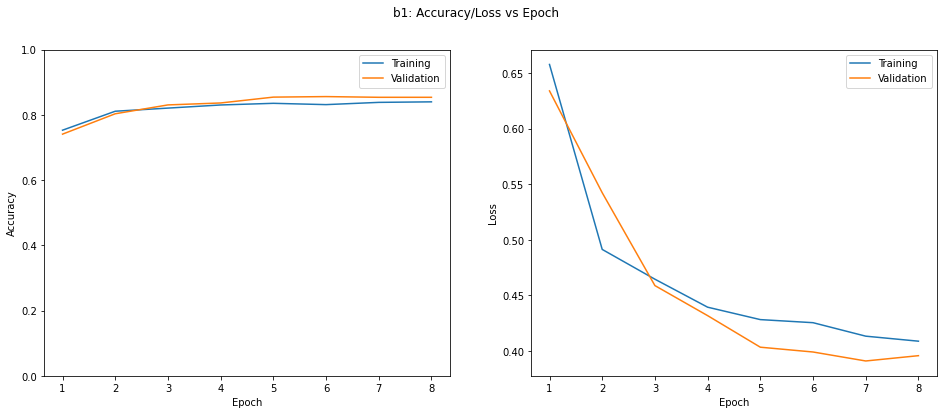

In [ ]:
plot_loss_acc(hist, 'b1')

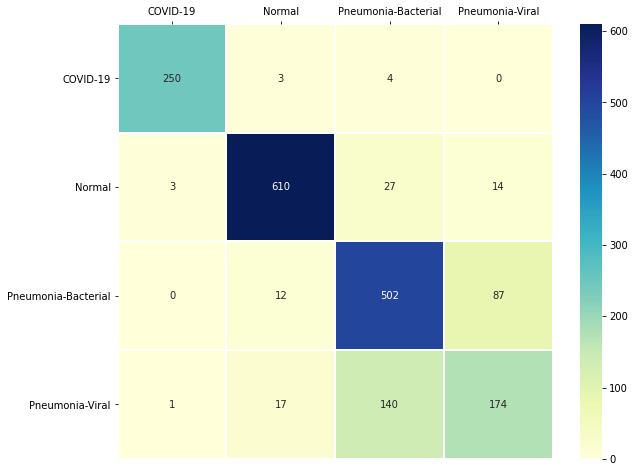

In [ ]:
plot_confusion_matrix(cm)

###Finetune

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=4)

Loaded pretrained weights for efficientnet-b1


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler, monitor='val_acc')
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.638041	accuracy: 0.756654	val_loss: 0.492693	val_accuracy: 0.818577
Validation accuracy increased (-inf --> 0.818577).  Saving model ...
Epoch: 2	loss: 0.359630	accuracy: 0.850444	val_loss: 0.375508	val_accuracy: 0.852797
Validation accuracy increased (0.818577 --> 0.852797).  Saving model ...
Epoch: 3	loss: 0.303229	accuracy: 0.873076	val_loss: 0.358781	val_accuracy: 0.849538
Epoch: 4	loss: 0.293119	accuracy: 0.878870	val_loss: 0.316919	val_accuracy: 0.866920
Validation accuracy increased (0.852797 --> 0.866920).  Saving model ...
Epoch: 5	loss: 0.245494	accuracy: 0.899692	val_loss: 0.327859	val_accuracy: 0.859859
Epoch: 6	loss: 0.241519	accuracy: 0.907116	val_loss: 0.306133	val_accuracy: 0.877241
Validation accuracy increased (0.866920 --> 0.877241).  Saving model ...
Epoch: 7	loss: 0.206175	accuracy: 0.923592	val_loss: 0.310817	val_accuracy: 0.877241
Epoch: 8	loss: 0.206541	accuracy: 0.920514	val_loss: 0.295134	val_accuracy: 0.884302
Validation accuracy increased (0

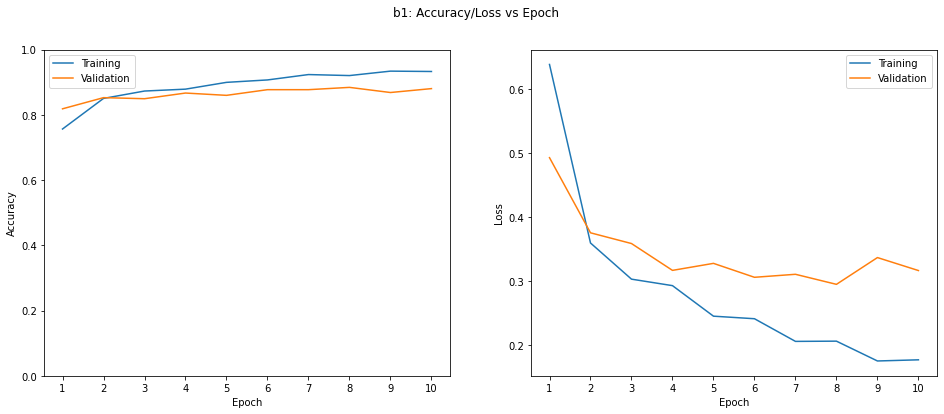

In [ ]:
plot_loss_acc(hist, 'b1')

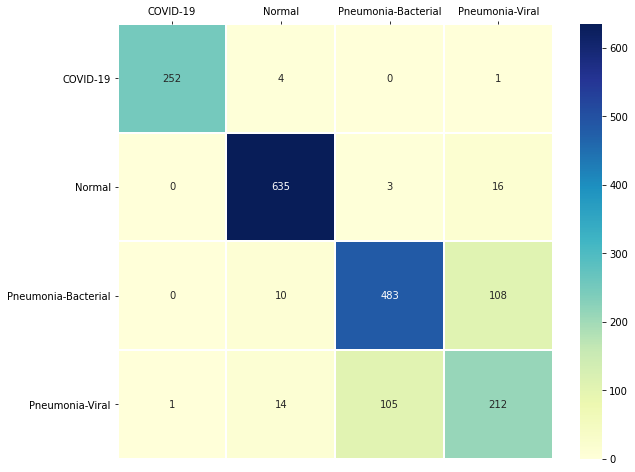

In [ ]:
plot_confusion_matrix(cm)

###Finetune + more layers

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b1')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Dropout(0.4),
                            nn.Linear(num_ftrs, 64),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=64),
                            nn.Dropout(0.4),
                            nn.Linear(64, 4)
                            )
model._fc = last_layers

Loaded pretrained weights for efficientnet-b1


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)
n_epochs = 40
patience = 5
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler, monitor='val_acc')
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.558122	accuracy: 0.769147	val_loss: 0.569674	val_accuracy: 0.734927
Validation accuracy increased (-inf --> 0.734927).  Saving model ...
Epoch: 2	loss: 0.362488	accuracy: 0.846279	val_loss: 0.311844	val_accuracy: 0.871809
Validation accuracy increased (0.734927 --> 0.871809).  Saving model ...
Epoch: 3	loss: 0.304333	accuracy: 0.872714	val_loss: 0.375004	val_accuracy: 0.850625
Epoch: 4	loss: 0.253612	accuracy: 0.896614	val_loss: 0.328973	val_accuracy: 0.858229
Epoch: 5	loss: 0.200278	accuracy: 0.920695	val_loss: 0.407036	val_accuracy: 0.835959
Epoch: 6	loss: 0.159650	accuracy: 0.937715	val_loss: 0.463865	val_accuracy: 0.813688
Epoch: 7	loss: 0.109949	accuracy: 0.961072	val_loss: 0.302556	val_accuracy: 0.906029
Validation accuracy increased (0.871809 --> 0.906029).  Saving model ...
Epoch: 8	loss: 0.064442	accuracy: 0.982980	val_loss: 0.303157	val_accuracy: 0.908745
Validation accuracy increased (0.906029 --> 0.908745).  Saving model ...
Epoch: 9	loss: 0.056547	accuracy

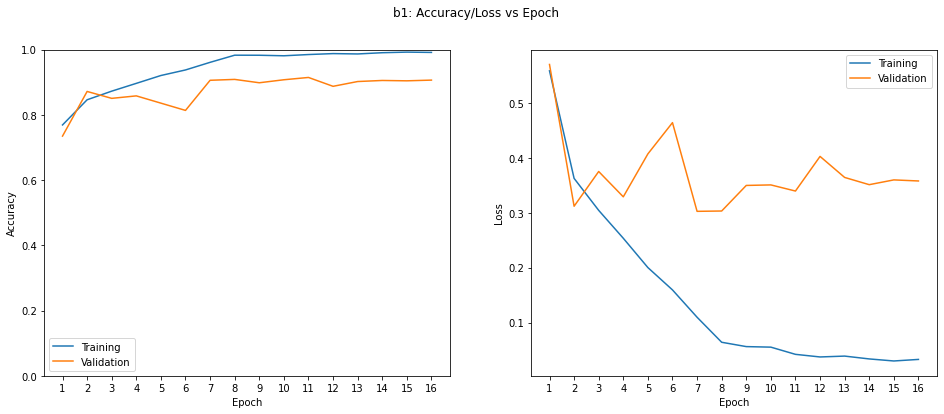

In [ ]:
plot_loss_acc(hist, 'b1')

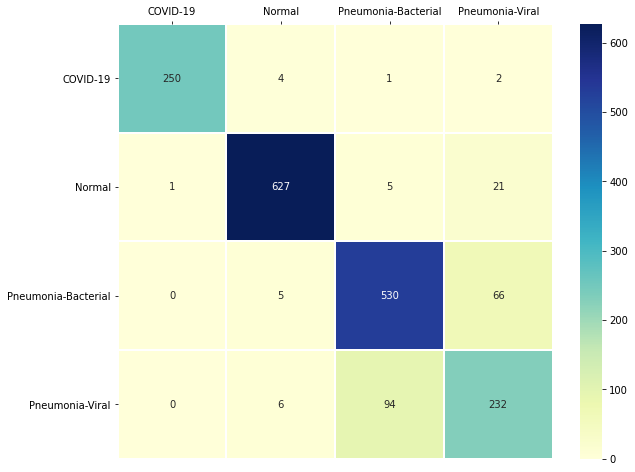

In [ ]:
plot_confusion_matrix(cm)

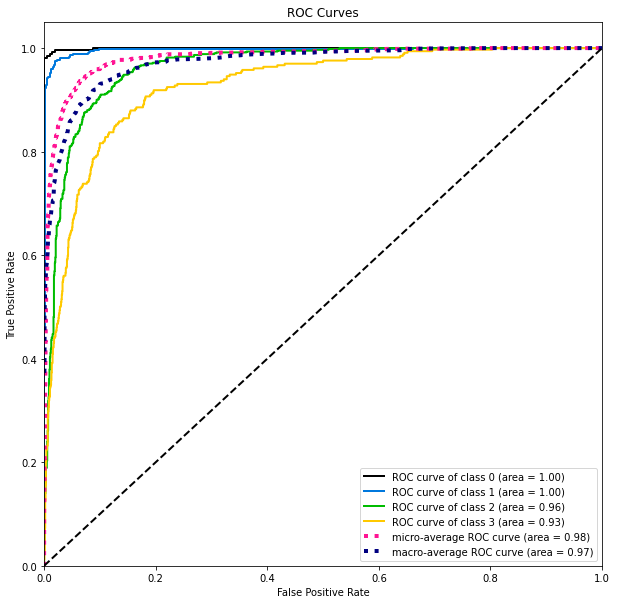

In [ ]:
y_true = image_datasets['test'].targets
skplt.metrics.plot_roc(y_true, y_pred_proba, figsize=(10,10))

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/dlproject/weights/efficientnet-b1.pt')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       257
           1       0.98      0.96      0.97       654
           2       0.84      0.88      0.86       601
           3       0.72      0.70      0.71       332

    accuracy                           0.89      1844
   macro avg       0.88      0.88      0.88      1844
weighted avg       0.89      0.89      0.89      1844



###Feature Extractor (B2: input image_size=260, batch_size=32)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b2')

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 4)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.692841	accuracy: 0.742712	val_loss: 0.650094	val_accuracy: 0.765888
Validation loss decreased (inf --> 0.650094).  Saving model ...
Epoch: 2	loss: 0.516108	accuracy: 0.808437	val_loss: 0.561603	val_accuracy: 0.800652
Validation loss decreased (0.650094 --> 0.561603).  Saving model ...
Epoch: 3	loss: 0.480075	accuracy: 0.818215	val_loss: 0.465546	val_accuracy: 0.831070
Validation loss decreased (0.561603 --> 0.465546).  Saving model ...
Epoch: 4	loss: 0.476028	accuracy: 0.814956	val_loss: 0.432945	val_accuracy: 0.833786
Validation loss decreased (0.465546 --> 0.432945).  Saving model ...
Epoch: 5	loss: 0.460741	accuracy: 0.819482	val_loss: 0.420044	val_accuracy: 0.835416
Validation loss decreased (0.432945 --> 0.420044).  Saving model ...
Epoch: 6	loss: 0.445475	accuracy: 0.823103	val_loss: 0.422497	val_accuracy: 0.838675
Epoch: 7	loss: 0.456868	accuracy: 0.820931	val_loss: 0.425672	val_accuracy: 0.840847
Epoch: 8	loss: 0.446330	accuracy: 0.824371	val_loss: 0.434515	val

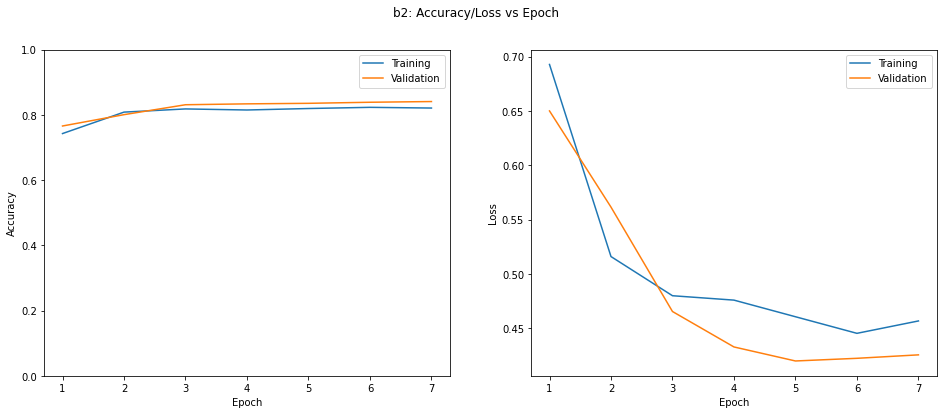

In [ ]:
plot_loss_acc(hist, 'b2')

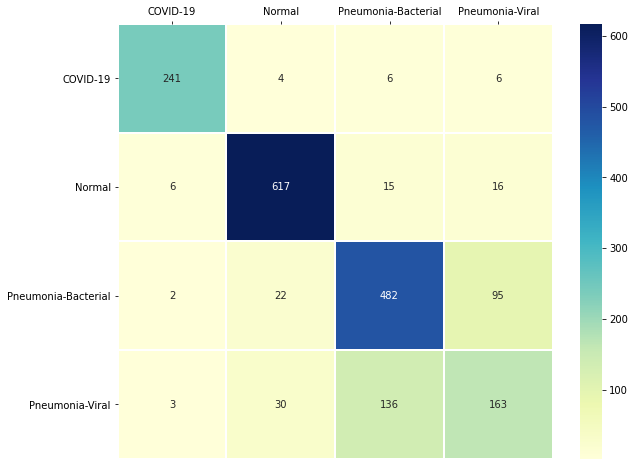

In [ ]:
plot_confusion_matrix(cm)

###Finetune

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=4)

Loaded pretrained weights for efficientnet-b2


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.740325	accuracy: 0.717726	val_loss: 0.542962	val_accuracy: 0.817490
Validation loss decreased (inf --> 0.542962).  Saving model ...
Epoch: 2	loss: 0.407366	accuracy: 0.837950	val_loss: 0.389810	val_accuracy: 0.845736
Validation loss decreased (0.542962 --> 0.389810).  Saving model ...
Epoch: 3	loss: 0.344088	accuracy: 0.857324	val_loss: 0.329240	val_accuracy: 0.862575
Validation loss decreased (0.389810 --> 0.329240).  Saving model ...
Epoch: 4	loss: 0.298831	accuracy: 0.881224	val_loss: 0.313857	val_accuracy: 0.866920
Validation loss decreased (0.329240 --> 0.313857).  Saving model ...
Epoch: 5	loss: 0.263899	accuracy: 0.890820	val_loss: 0.329535	val_accuracy: 0.859316
Epoch: 6	loss: 0.258015	accuracy: 0.898968	val_loss: 0.303420	val_accuracy: 0.873438
Validation loss decreased (0.313857 --> 0.303420).  Saving model ...
Epoch: 7	loss: 0.247204	accuracy: 0.900779	val_loss: 0.298783	val_accuracy: 0.879957
Validation loss decreased (0.303420 --> 0.298783).  Saving model 

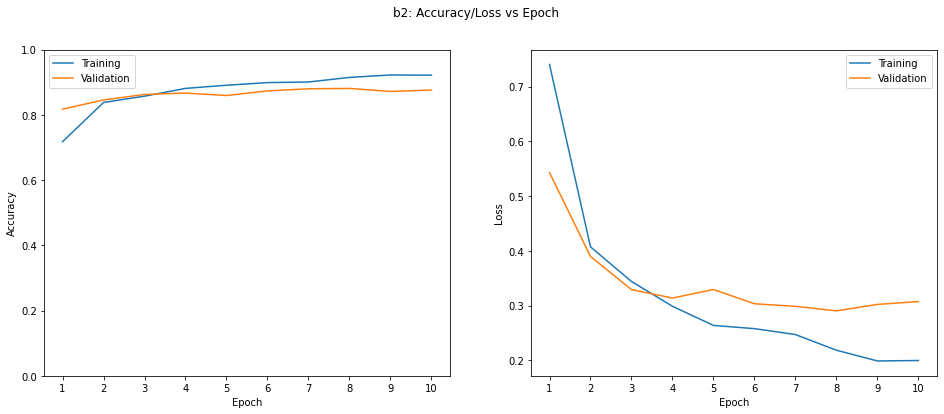

In [ ]:
plot_loss_acc(hist, 'b2')

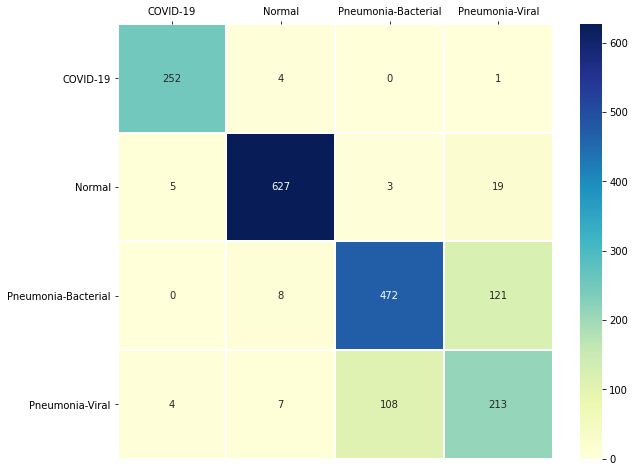

In [ ]:
plot_confusion_matrix(cm)

###Finetune + more layers

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b2')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Dropout(0.3),
                            nn.Linear(num_ftrs, 64),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=64),
                            nn.Dropout(0.3),
                            nn.Linear(64, 4)
                            )
model._fc = last_layers

Loaded pretrained weights for efficientnet-b2


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 40
patience = 10
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler, monitor='val_acc')
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.534018	accuracy: 0.787796	val_loss: 0.404758	val_accuracy: 0.840304
Validation accuracy increased (-inf --> 0.840304).  Saving model ...
Epoch: 2	loss: 0.337332	accuracy: 0.857324	val_loss: 0.339322	val_accuracy: 0.845736
Validation accuracy increased (0.840304 --> 0.845736).  Saving model ...
Epoch: 3	loss: 0.284177	accuracy: 0.881948	val_loss: 0.338484	val_accuracy: 0.866920
Validation accuracy increased (0.845736 --> 0.866920).  Saving model ...
Epoch: 4	loss: 0.217477	accuracy: 0.915988	val_loss: 0.311227	val_accuracy: 0.874525
Validation accuracy increased (0.866920 --> 0.874525).  Saving model ...
Epoch: 5	loss: 0.178344	accuracy: 0.934637	val_loss: 0.376281	val_accuracy: 0.844650
Epoch: 6	loss: 0.152538	accuracy: 0.943690	val_loss: 0.307870	val_accuracy: 0.883216
Validation accuracy increased (0.874525 --> 0.883216).  Saving model ...
Epoch: 7	loss: 0.118304	accuracy: 0.960710	val_loss: 0.355682	val_accuracy: 0.881586
Epoch: 8	loss: 0.114349	accuracy: 0.959986	v

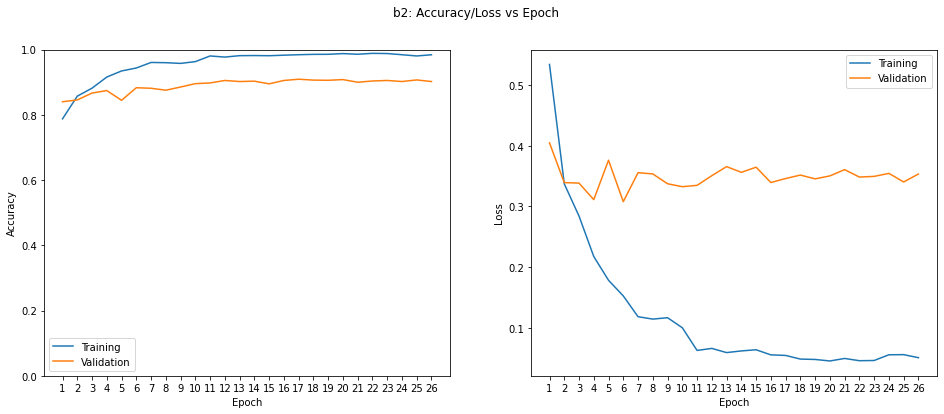

In [ ]:
plot_loss_acc(hist, 'b2')

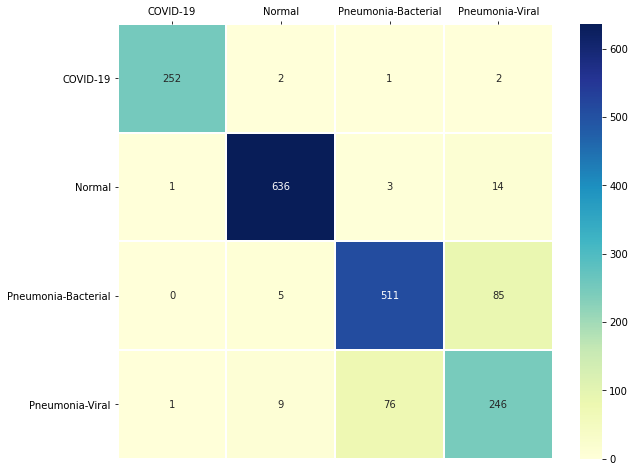

In [ ]:
plot_confusion_matrix(cm)

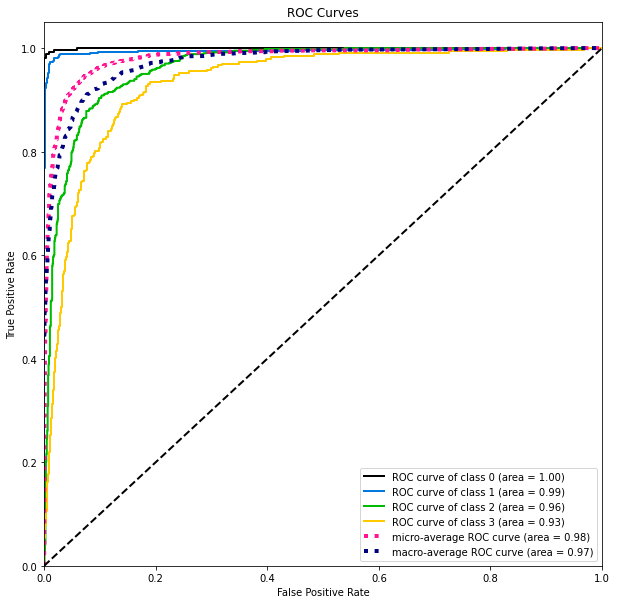

In [ ]:
skplt.metrics.plot_roc(y_true, y_pred_proba, figsize=(10,10))

###Feature Extractor (B3, input image_size=300, batch_size=16)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3')

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 4)

Loaded pretrained weights for efficientnet-b3


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.620238	accuracy: 0.764077	val_loss: 0.742051	val_accuracy: 0.695817
Validation loss decreased (inf --> 0.742051).  Saving model ...
Epoch: 2	loss: 0.494090	accuracy: 0.802643	val_loss: 0.492372	val_accuracy: 0.799565
Validation loss decreased (0.742051 --> 0.492372).  Saving model ...
Epoch: 3	loss: 0.502055	accuracy: 0.805540	val_loss: 0.426636	val_accuracy: 0.834872
Validation loss decreased (0.492372 --> 0.426636).  Saving model ...
Epoch: 4	loss: 0.471134	accuracy: 0.809886	val_loss: 0.440051	val_accuracy: 0.818034
Epoch: 5	loss: 0.474907	accuracy: 0.806084	val_loss: 0.450184	val_accuracy: 0.813688
Epoch: 6	loss: 0.486802	accuracy: 0.802281	val_loss: 0.414275	val_accuracy: 0.835416
Validation loss decreased (0.426636 --> 0.414275).  Saving model ...
Epoch: 7	loss: 0.471949	accuracy: 0.817128	val_loss: 0.431953	val_accuracy: 0.825638
Epoch: 8	loss: 0.456085	accuracy: 0.820750	val_loss: 0.420156	val_accuracy: 0.833786
Epoch: 9	loss: 0.459059	accuracy: 0.811153	val_lo

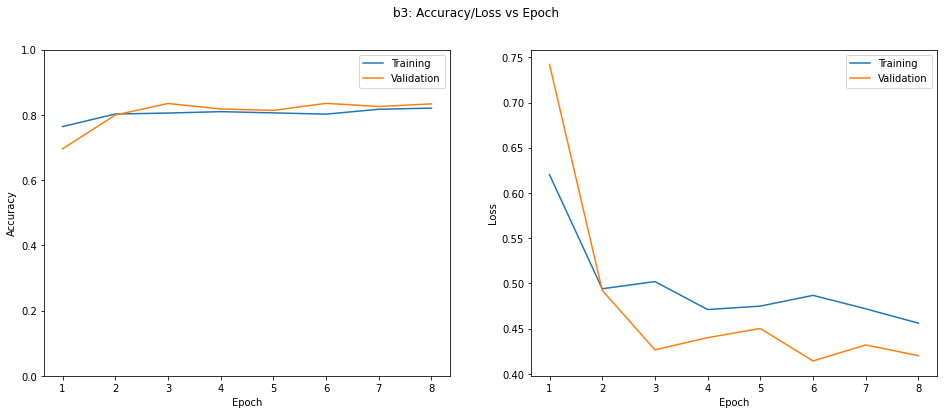

In [ ]:
plot_loss_acc(hist, 'b3')

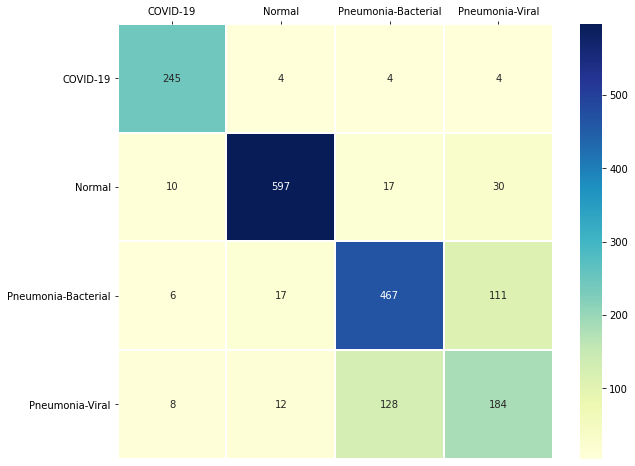

In [ ]:
plot_confusion_matrix(cm)

###Finetune

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=4)

Loaded pretrained weights for efficientnet-b3


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.595213	accuracy: 0.771682	val_loss: 0.445979	val_accuracy: 0.831070
Validation loss decreased (inf --> 0.445979).  Saving model ...
Epoch: 2	loss: 0.364640	accuracy: 0.851349	val_loss: 0.316434	val_accuracy: 0.872352
Validation loss decreased (0.445979 --> 0.316434).  Saving model ...
Epoch: 3	loss: 0.290624	accuracy: 0.883397	val_loss: 0.312972	val_accuracy: 0.877241
Validation loss decreased (0.316434 --> 0.312972).  Saving model ...
Epoch: 4	loss: 0.247385	accuracy: 0.901684	val_loss: 0.354381	val_accuracy: 0.872352
Epoch: 5	loss: 0.238222	accuracy: 0.904762	val_loss: 0.317509	val_accuracy: 0.868007
Epoch: 6	loss: 0.242246	accuracy: 0.901322	val_loss: 0.301808	val_accuracy: 0.878327
Validation loss decreased (0.312972 --> 0.301808).  Saving model ...
Epoch: 7	loss: 0.192849	accuracy: 0.930292	val_loss: 0.304096	val_accuracy: 0.882129
Epoch: 8	loss: 0.192323	accuracy: 0.926489	val_loss: 0.304362	val_accuracy: 0.876697
Epoch: 9	loss: 0.190949	accuracy: 0.926127	val_lo

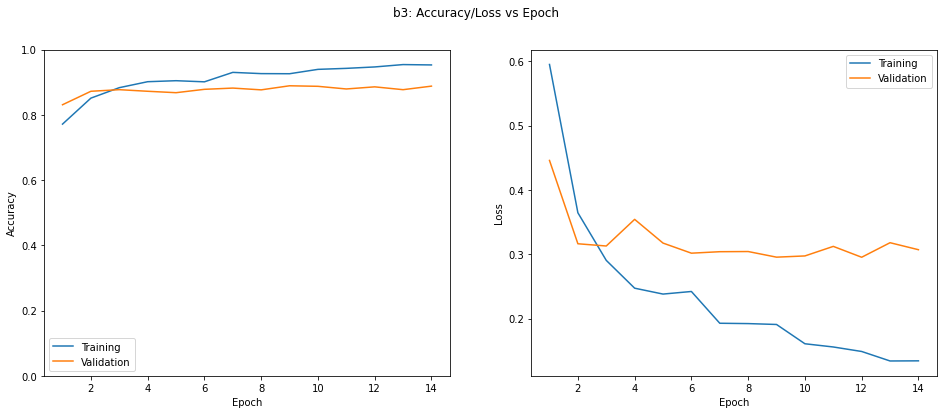

In [ ]:
plot_loss_acc(hist, 'b3')

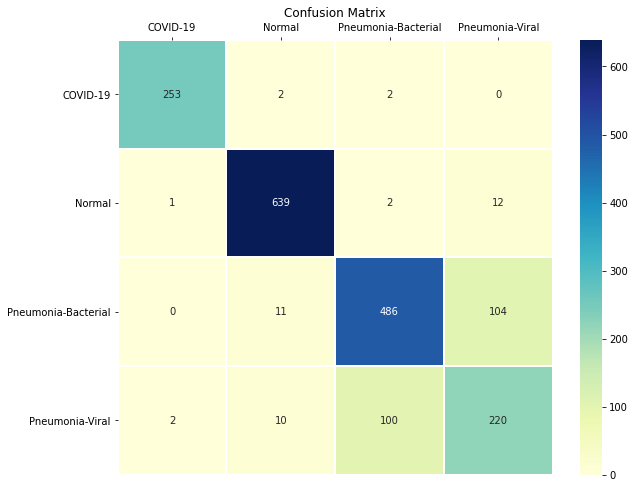

In [ ]:
plot_confusion_matrix(cm)

###Finetune + more layers (Best result)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            # nn.BatchNorm1d(num_features=num_ftrs),
                            # nn.Dropout(0.5),
                            # nn.Linear(num_ftrs, 64),
                            # nn.ReLU(),
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Dropout(0.3),
                            nn.Linear(num_ftrs, 4)
                            )
model._fc = last_layers

Loaded pretrained weights for efficientnet-b3


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
n_epochs = 40
patience = 10
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler, monitor='val_acc')
cm, y_pred, y_pred_proba = test(model, criterion)

Epoch: 1	loss: 0.610292	accuracy: 0.765164	val_loss: 0.479428	val_accuracy: 0.827268
Validation accuracy increased (-inf --> 0.827268).  Saving model ...
Epoch: 2	loss: 0.445647	accuracy: 0.834872	val_loss: 0.460859	val_accuracy: 0.810972
Epoch: 3	loss: 0.362866	accuracy: 0.857867	val_loss: 0.472450	val_accuracy: 0.806084
Epoch: 4	loss: 0.289418	accuracy: 0.891544	val_loss: 0.338834	val_accuracy: 0.879413
Validation accuracy increased (0.827268 --> 0.879413).  Saving model ...
Epoch: 5	loss: 0.243233	accuracy: 0.911823	val_loss: 0.338329	val_accuracy: 0.885388
Validation accuracy increased (0.879413 --> 0.885388).  Saving model ...
Epoch: 6	loss: 0.157597	accuracy: 0.939163	val_loss: 0.383261	val_accuracy: 0.892450
Validation accuracy increased (0.885388 --> 0.892450).  Saving model ...
Epoch: 7	loss: 0.143533	accuracy: 0.949846	val_loss: 0.402979	val_accuracy: 0.892993
Validation accuracy increased (0.892450 --> 0.892993).  Saving model ...
Epoch: 8	loss: 0.151988	accuracy: 0.948579	v

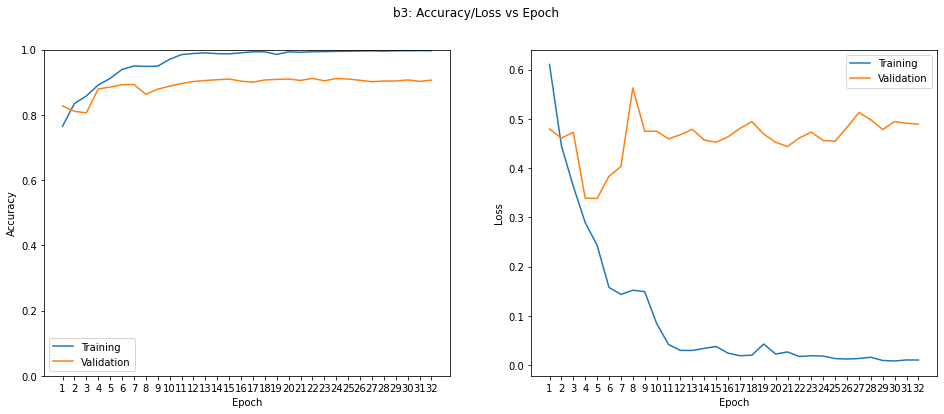

In [ ]:
plot_loss_acc(hist, 'b3')

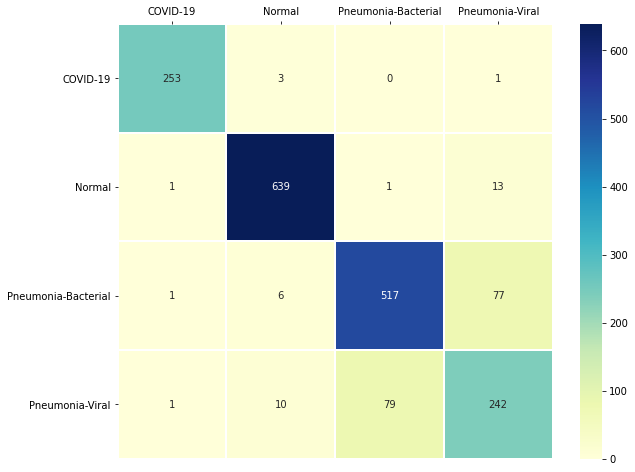

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
y_true = image_datasets['test'].targets
for i in range(4):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:,i], pos_label=i)
    print('AUC of Class {}: {:.6f}'.format(i, auc(fpr, tpr)))

AUC of Class 0: 0.999358
AUC of Class 1: 0.997537
AUC of Class 2: 0.965633
AUC of Class 3: 0.937028


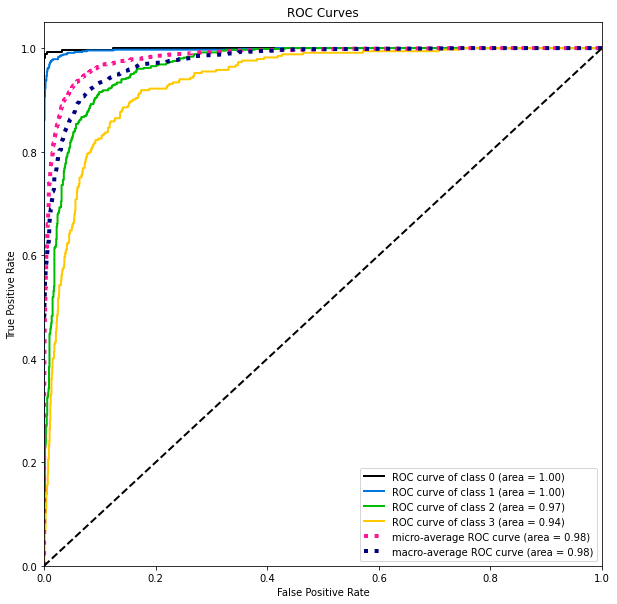

In [ ]:
y_true = image_datasets['test'].targets
skplt.metrics.plot_roc(y_true, y_pred_proba, figsize=(10,10))

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/dlproject/weights/efficientnet-b3.pt')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       257
           1       0.97      0.98      0.97       654
           2       0.87      0.86      0.86       601
           3       0.73      0.73      0.73       332

    accuracy                           0.90      1844
   macro avg       0.89      0.89      0.89      1844
weighted avg       0.90      0.90      0.90      1844



In [ ]:
import pandas as pd

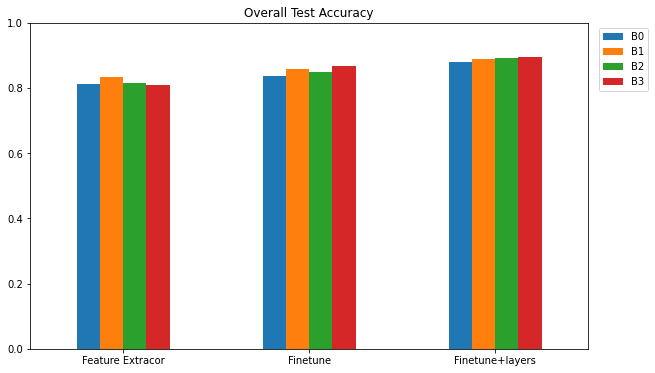

In [ ]:
acc = {'B0':[0.81290672451193, 0.836225596529284, 0.879067245119305],
       'B1':[0.832971800433839, 0.857917570498915, 0.888828633405639],
       'B2':[0.815075921908893, 0.848156182212581, 0.892082429501084],
       'B3':[0.809652928416486, 0.866594360086767, 0.895336225596529]
       }

df = pd.DataFrame(acc, index=['Feature Extracor', 'Finetune', 'Finetune+layers'])
df.plot.bar(figsize=(10,6))
plt.xticks(rotation=0)
plt.title('Overall Test Accuracy')
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

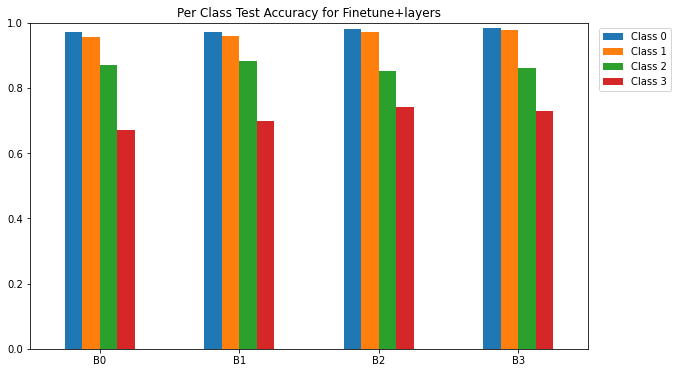

In [ ]:
# Test accuracy of class 0: 0.9844 B3
# Test accuracy of class 1: 0.9771
# Test accuracy of class 2: 0.8602
# Test accuracy of class 3: 0.7289

# Test accuracy of class 0: 0.9805 B2
# Test accuracy of class 1: 0.9725
# Test accuracy of class 2: 0.8502
# Test accuracy of class 3: 0.7410

# Test accuracy of class 0: 0.9728 B1
# Test accuracy of class 1: 0.9587
# Test accuracy of class 2: 0.8819
# Test accuracy of class 3: 0.6988

# Test accuracy of class 0: 0.9728 B0
# Test accuracy of class 1: 0.9572
# Test accuracy of class 2: 0.8686
# Test accuracy of class 3: 0.6717

per_cls_acc = {'Class 0':[0.9728,0.9728,0.9805,0.9844],
               'Class 1':[0.9572,0.9587,0.9725,0.9771],
               'Class 2':[0.8686,0.8819,0.8502,0.8602],
               'Class 3':[0.6717,0.6988,0.7410,0.7289]}

nets = ['B0', 'B1', 'B2', 'B3']
df = pd.DataFrame(per_cls_acc, index=nets)
df.plot.bar(figsize=(10,6))
plt.xticks(rotation=0)
plt.title('Per Class Test Accuracy for Finetune+layers')
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

###Knowledge Distillation

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 84) # 53x53 image dimension
        self.fc2 = nn.Linear(84, 4)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=224) # resize input to 224
        x = torch.max_pool2d(torch.relu(self.conv1(x)), (2, 2))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class DistillationLoss(nn.Module):

    def forward(self, student_output, teacher_output, T):
        distill_loss = None
        P = nn.functional.softmax(teacher_output / T, dim=1)
        Q = nn.functional.log_softmax(student_output / T, dim=1)
        distill_loss = nn.KLDivLoss(reduction='batchmean')(Q, P)
        # distill_loss = -(P * Q).sum(dim=1).mean()
        return distill_loss * T**2


def distill(student, teacher, optimizer, n_epochs, patience, alpha, T, scheduler=None, monitor='val_loss'):
    hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    not_improved = 0
    best_weights = None
    val_loss_min = np.Inf
    val_acc_max = -np.Inf
    
    teacher.eval()
    criterion_student = nn.CrossEntropyLoss()
    criterion_distill = DistillationLoss()

    for epoch in range(n_epochs):
        epoch_stats = []
        for phase in ['train', 'val']:
            if phase == 'train':
                student.train()
            if phase == 'val':
                student.eval()
            losses = 0.0
            corrects = 0
            for data, target in image_loaders[phase]:
                data = data.cuda()
                target = target.cuda()

                out = student(data)
                with torch.no_grad():
                    teacher_output = teacher(data)
                loss_distill = criterion_distill(out, teacher_output, T)
                loss_student = criterion_student(out, target)
                loss = alpha * loss_student + (1 - alpha) * loss_distill

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(out, dim=-1)
                losses += loss.item() * data.size(0)
                corrects += torch.sum(preds==target.data).item()

            if phase == 'train' and scheduler:
                scheduler.step()
            
            epoch_stats += [losses / dataset_sizes[phase],
                            corrects / dataset_sizes[phase]]

        train_loss, train_acc, val_loss, val_acc = epoch_stats
        print('Epoch: {}\tloss: {:.6f}\taccuracy: {:.6f}\tval_loss: {:.6f}\tval_accuracy: {:.6f}'
              .format(epoch+1, train_loss, train_acc, val_loss, val_acc))
        hist['loss'] += [train_loss]
        hist['acc'] += [train_acc]
        hist['val_loss'] += [val_loss]
        hist['val_acc'] += [val_acc]

        if monitor=='val_loss' and val_loss < val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_loss_min, val_loss))
            best_weights = copy.deepcopy(student.state_dict())
            val_loss_min = val_loss
            not_improved = 0

        elif monitor=='val_acc' and val_acc > val_acc_max:
            print('Validation accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_acc_max, val_acc))
            best_weights = copy.deepcopy(student.state_dict())
            val_acc_max = val_acc
            not_improved = 0

        else:
            not_improved += 1
            if not_improved == patience and epoch < n_epochs-1:
                print('Early stopping ...')
                break
        
    student.load_state_dict(best_weights)
    return student, hist

###KD for LeNet

In [ ]:
# Train student LeNet without KD
student = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
n_epochs = 10
patience = 3
student, hist = train(student, criterion, optimizer, n_epochs, patience, monitor='val_acc')
cm, y_pred, y_pred_proba = test(student, criterion)

Epoch: 1	loss: 0.679315	accuracy: 0.708311	val_loss: 0.533667	val_accuracy: 0.771320
Validation accuracy increased (-inf --> 0.771320).  Saving model ...
Epoch: 2	loss: 0.475653	accuracy: 0.802281	val_loss: 0.482540	val_accuracy: 0.794677
Validation accuracy increased (0.771320 --> 0.794677).  Saving model ...
Epoch: 3	loss: 0.430368	accuracy: 0.812421	val_loss: 0.410752	val_accuracy: 0.841391
Validation accuracy increased (0.794677 --> 0.841391).  Saving model ...
Epoch: 4	loss: 0.388825	accuracy: 0.832337	val_loss: 0.460893	val_accuracy: 0.791961
Epoch: 5	loss: 0.348418	accuracy: 0.843744	val_loss: 0.414122	val_accuracy: 0.831070
Epoch: 6	loss: 0.317249	accuracy: 0.863842	val_loss: 0.384599	val_accuracy: 0.840304
Early stopping ...
Test loss: 0.44224649524708115
Test accuracy: 0.8004338394793926
Test accuracy of class 0: 0.9455
Test accuracy of class 1: 0.9434
Test accuracy of class 2: 0.8220
Test accuracy of class 3: 0.3675


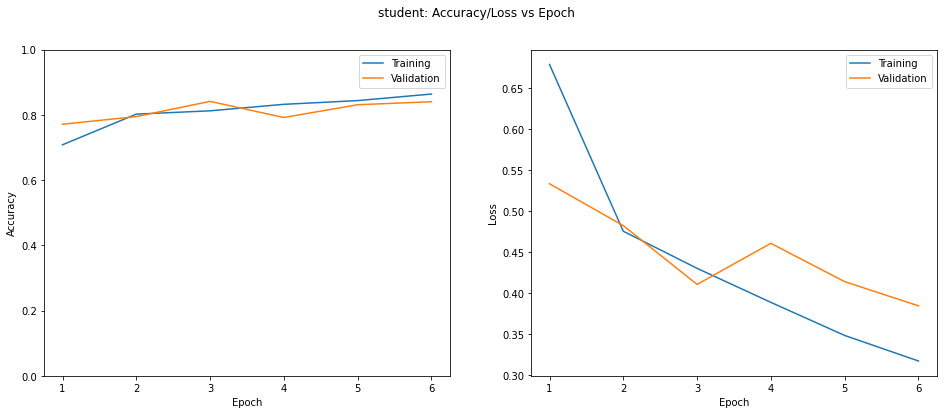

In [ ]:
plot_loss_acc(hist, 'student')

In [ ]:
# Load trained teacher B3
model = EfficientNet.from_pretrained('efficientnet-b3')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Dropout(0.3),
                            nn.Linear(num_ftrs, 4)
                            )
model._fc = last_layers

model.load_state_dict(torch.load('/content/drive/MyDrive/dlproject/weights/efficientnet-b3.pt'))
model.cuda()
model.eval()

# Train student with KD
student = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
n_epochs = 10
patience = 3
alpha = 0.1
T = 3
student, hist = distill(student, model, optimizer, n_epochs, patience, alpha, T, monitor='val_acc')
cm, y_pred, y_pred_proba = test(student, criterion)

Loaded pretrained weights for efficientnet-b3
Epoch: 1	loss: 5.229503	accuracy: 0.710664	val_loss: 3.167251	val_accuracy: 0.752309
Validation accuracy increased (-inf --> 0.752309).  Saving model ...
Epoch: 2	loss: 3.294058	accuracy: 0.806446	val_loss: 1.969740	val_accuracy: 0.831613
Validation accuracy increased (0.752309 --> 0.831613).  Saving model ...
Epoch: 3	loss: 2.606807	accuracy: 0.847185	val_loss: 2.048528	val_accuracy: 0.819663
Epoch: 4	loss: 1.909117	accuracy: 0.888104	val_loss: 1.816628	val_accuracy: 0.839218
Validation accuracy increased (0.831613 --> 0.839218).  Saving model ...
Epoch: 5	loss: 1.285019	accuracy: 0.932102	val_loss: 1.973714	val_accuracy: 0.853341
Validation accuracy increased (0.839218 --> 0.853341).  Saving model ...
Epoch: 6	loss: 0.771761	accuracy: 0.972117	val_loss: 1.852736	val_accuracy: 0.858229
Validation accuracy increased (0.853341 --> 0.858229).  Saving model ...
Epoch: 7	loss: 0.359888	accuracy: 0.997103	val_loss: 1.995787	val_accuracy: 0.86257

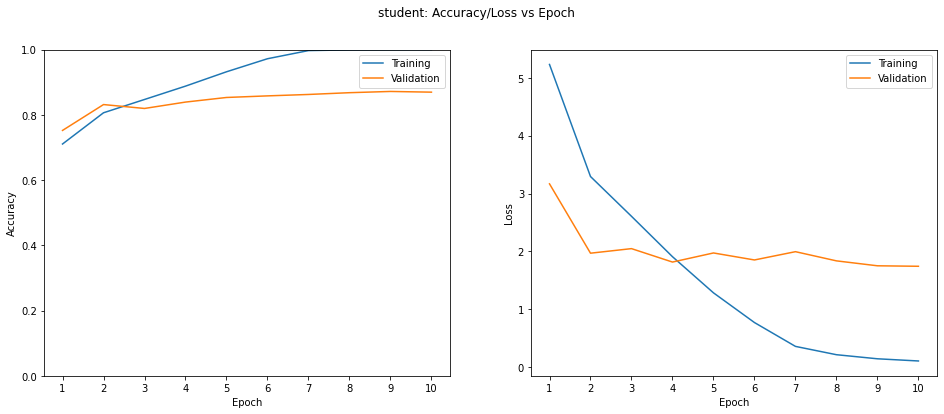

In [ ]:
plot_loss_acc(hist, 'student')

###KD for B0-3

In [ ]:
names = ['efficientnet-b0','efficientnet-b1','efficientnet-b2','efficientnet-b3']

for name in names:
    print('\nTrain student {} (Feature extractor) without KD ..'.format(name))
    student = EfficientNet.from_pretrained(name)

    # Freeze model weights
    for param in student.parameters():
        param.requires_grad = False

    num_ftrs = student._fc.in_features
    student._fc = nn.Linear(num_ftrs, 4)
    student.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    n_epochs = 10
    patience = 3
    student, hist = train(student, criterion, optimizer, n_epochs, patience, monitor='val_acc')
    cm, y_pred, y_pred_proba = test(student, criterion)

    print('\nLoad trained teacher B3')
    model = EfficientNet.from_pretrained('efficientnet-b3')

    num_ftrs = model._fc.in_features
    last_layers = nn.Sequential(
                                nn.BatchNorm1d(num_features=num_ftrs),
                                nn.Dropout(0.3),
                                nn.Linear(num_ftrs, 4)
                                )
    model._fc = last_layers

    model.load_state_dict(torch.load('/content/drive/MyDrive/dlproject/weights/efficientnet-b3.pt'))
    model.cuda()
    model.eval()

    print('\nTrain student {} (Feature extractor) with KD ..'.format(name))
    student = EfficientNet.from_pretrained(name)

    # Freeze model weights
    for param in student.parameters():
        param.requires_grad = False

    num_ftrs = student._fc.in_features
    student._fc = nn.Linear(num_ftrs, 4)
    student.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    n_epochs = 10
    patience = 3
    alpha = 0.1
    T = 3
    student, hist = distill(student, model, optimizer, n_epochs, patience, alpha, T, monitor='val_acc')
    cm, y_pred, y_pred_proba = test(student, criterion)


Train student efficientnet-b0 (Feature extractor) without KD ..
Loaded pretrained weights for efficientnet-b0
Epoch: 1	loss: 0.932537	accuracy: 0.662321	val_loss: 0.907992	val_accuracy: 0.694188
Validation accuracy increased (-inf --> 0.694188).  Saving model ...
Epoch: 2	loss: 0.675843	accuracy: 0.780554	val_loss: 0.692335	val_accuracy: 0.768061
Validation accuracy increased (0.694188 --> 0.768061).  Saving model ...
Epoch: 3	loss: 0.611616	accuracy: 0.789788	val_loss: 0.574795	val_accuracy: 0.804454
Validation accuracy increased (0.768061 --> 0.804454).  Saving model ...
Epoch: 4	loss: 0.574960	accuracy: 0.799022	val_loss: 0.620336	val_accuracy: 0.809343
Validation accuracy increased (0.804454 --> 0.809343).  Saving model ...
Epoch: 5	loss: 0.552645	accuracy: 0.800652	val_loss: 0.538163	val_accuracy: 0.809343
Epoch: 6	loss: 0.522351	accuracy: 0.809524	val_loss: 0.554935	val_accuracy: 0.801195
Epoch: 7	loss: 0.521690	accuracy: 0.807894	val_loss: 0.534952	val_accuracy: 0.810429
Valida

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1
Epoch: 1	loss: 0.895624	accuracy: 0.684592	val_loss: 0.809862	val_accuracy: 0.744161
Validation accuracy increased (-inf --> 0.744161).  Saving model ...
Epoch: 2	loss: 0.654134	accuracy: 0.775665	val_loss: 0.572933	val_accuracy: 0.814775
Validation accuracy increased (0.744161 --> 0.814775).  Saving model ...
Epoch: 3	loss: 0.594678	accuracy: 0.786891	val_loss: 0.528685	val_accuracy: 0.823466
Validation accuracy increased (0.814775 --> 0.823466).  Saving model ...
Epoch: 4	loss: 0.557756	accuracy: 0.796850	val_loss: 0.511750	val_accuracy: 0.825638
Validation accuracy increased (0.823466 --> 0.825638).  Saving model ...
Epoch: 5	loss: 0.528666	accuracy: 0.807351	val_loss: 0.487948	val_accuracy: 0.830527
Validation accuracy increased (0.825638 --> 0.830527).  Saving model ...
Epoch: 6	loss: 0.524049	accuracy: 0.810791	val_loss: 0.474605	val_accuracy: 0.833786
Validation accuracy increased (0.830527 --> 0.833786).  Saving model ...
Epoch: 7	

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2
Epoch: 1	loss: 0.938734	accuracy: 0.658700	val_loss: 0.836931	val_accuracy: 0.745790
Validation accuracy increased (-inf --> 0.745790).  Saving model ...
Epoch: 2	loss: 0.696162	accuracy: 0.759008	val_loss: 0.619944	val_accuracy: 0.801738
Validation accuracy increased (0.745790 --> 0.801738).  Saving model ...
Epoch: 3	loss: 0.626145	accuracy: 0.779649	val_loss: 0.573321	val_accuracy: 0.809343
Validation accuracy increased (0.801738 --> 0.809343).  Saving model ...
Epoch: 4	loss: 0.599173	accuracy: 0.784175	val_loss: 0.598004	val_accuracy: 0.816947
Validation accuracy increased (0.809343 --> 0.816947).  Saving model ...
Epoch: 5	loss: 0.580017	accuracy: 0.791056	val_loss: 0.573497	val_accuracy: 0.820750
Validation accuracy increased (0.816947 --> 0.820750).  Saving model ...
Epoch: 6	loss: 0.544571	accuracy: 0.801557	val_loss: 0.572860	val_accuracy: 0.826725
Validation accuracy increased (0.820750 --> 0.826725).  Saving model ...
Epoch: 7	

In [ ]:
names = ['efficientnet-b0','efficientnet-b1','efficientnet-b2','efficientnet-b3']

for name in names:
    print('\nTrain student {} (Finetune) without KD ..'.format(name))
    student = EfficientNet.from_pretrained(name, num_classes=4)
    student.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    n_epochs = 10
    patience = 3
    student, hist = train(student, criterion, optimizer, n_epochs, patience, monitor='val_acc')
    cm, y_pred, y_pred_proba = test(student, criterion)

    print('\nLoad trained teacher B3')
    model = EfficientNet.from_pretrained('efficientnet-b3')

    num_ftrs = model._fc.in_features
    last_layers = nn.Sequential(
                                nn.BatchNorm1d(num_features=num_ftrs),
                                nn.Dropout(0.3),
                                nn.Linear(num_ftrs, 4)
                                )
    model._fc = last_layers

    model.load_state_dict(torch.load('/content/drive/MyDrive/dlproject/weights/efficientnet-b3.pt'))
    model.cuda()
    model.eval()

    print('\nTrain student {} (Finetune) with KD ..'.format(name))
    student = EfficientNet.from_pretrained(name, num_classes=4)
    student.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    n_epochs = 10
    patience = 3
    alpha = 0.1
    T = 3
    student, hist = distill(student, model, optimizer, n_epochs, patience, alpha, T, monitor='val_acc')
    cm, y_pred, y_pred_proba = test(student, criterion)


Train student efficientnet-b0 (Finetune) without KD ..
Loaded pretrained weights for efficientnet-b0
Epoch: 1	loss: 0.769309	accuracy: 0.718269	val_loss: 0.551697	val_accuracy: 0.815861
Validation accuracy increased (-inf --> 0.815861).  Saving model ...
Epoch: 2	loss: 0.462255	accuracy: 0.826544	val_loss: 0.389075	val_accuracy: 0.848995
Validation accuracy increased (0.815861 --> 0.848995).  Saving model ...
Epoch: 3	loss: 0.393296	accuracy: 0.842477	val_loss: 0.364913	val_accuracy: 0.846279
Epoch: 4	loss: 0.359036	accuracy: 0.857324	val_loss: 0.330635	val_accuracy: 0.862575
Validation accuracy increased (0.848995 --> 0.862575).  Saving model ...
Epoch: 5	loss: 0.322920	accuracy: 0.870541	val_loss: 0.327818	val_accuracy: 0.859859
Epoch: 6	loss: 0.307723	accuracy: 0.875068	val_loss: 0.318238	val_accuracy: 0.873438
Validation accuracy increased (0.862575 --> 0.873438).  Saving model ...
Epoch: 7	loss: 0.275773	accuracy: 0.886837	val_loss: 0.294467	val_accuracy: 0.877241
Validation accu